In [22]:
from openai import OpenAI
from pydantic import BaseModel
import base64
import pandas as pd
import os
import json

In [23]:
class keywordsModel(BaseModel):
    keywords: list[str]

In [24]:
class chart_output:
    def __init__(self):
        self.ChartAnalysis_prompt = """
            You are GPT-4o-mini, a reasoning model specialized in analyzing charts and their captions. Your task is to carefully examine the provided chart and caption, then clearly identify and list the attributes used in the chart.

            When presented with a chart and its caption:
                1. Carefully inspect the chart provided.
                2. **Let's think step-by-step.** First, carefully inspect the provided chart and caption. Identify and list all attributes used in the chart. 
                3. **Briefly explain** how each attribute is represented or visualized in the chart (e.g., axis labels, legends, colors, data points).
                4. **Clearly separate** your response into two sections:
                    a. "**Identified Attributes:**" (list attributes succinctly)
                    b. "**Visualization Explanation:**" (briefly describe how each attribute is visualized)
                5. **Clearly summarize** the specific chart variables used (e.g., x-axis, y-axis, legend, color encoding) separately at the end of your response.

            Important instructions for optimal performance:

            1. Be concise and direct in your analysis.
            2. Do not include unnecessary examples or additional context beyond what is provided.
            3. Do not generate or assume any information not explicitly present in the provided chart and caption.
            4. Leverage your internal chain-of-thought reasoning capability without explicit prompting for step-by-step reasoning.
            5. Ensure your output is accurate, consistent, and directly based on the provided data only.
            """
        
        self.keyword_extraction_system_prompt = """ 
            You are a specialized Keyword Extraction GPT designed to distill chart analyses into semantic keywords.

            Your task is to analyze the provided chart description (which includes "Identified Attributes", "Visualization Explanation", and "Summary of Chart Variables") and extract the most significant keywords that represent:

            1. Core variables/attributes present in the chart
            2. Key measurement units and scales
            3. Central scientific or data concepts being visualized
            4. Important methodologies or data types

            Guidelines:
            - Focus on domain-specific terminology rather than generic terms
            - Include units of measurement when semantically relevant
            - Extract only terms explicitly present or strongly implied in the analysis
            - Limit to 8-12 keywords for clarity

            Append the extracted keywords to the end of your response in a list format.

            Do not include any explanations or additional commentary.
            """
        self.client = OpenAI(api_key=os.environ["OPENAI_API_KEY_personal"])
        self.df = pd.read_excel("ChartswithCaptions.xlsx")

    def encode_image(self,image_path):

        caption = self.df[self.df["imageid"]==int(image_path.split("/")[1].split(".")[0])]["full_caption"].values[0]

        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode("utf-8"), caption
        
    def get_chart_analysis(self, image_path):
        image, caption = self.encode_image(image_path)
        response = self.client.chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": self.ChartAnalysis_prompt},
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": f"Here is the caption for the image: {caption}"},
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{image}"
                            }
                        }
                    ],
                }
            ]
        )
        return response.choices[0].message.content
    
    def get_keywords(self, analysis):
        keywords_generated_1 = self.client.beta.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": self.keyword_extraction_system_prompt},
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": f"Here is the Chart Analysis output for chart: {analysis}"}
                    ],
                }
            ],
            response_format=keywordsModel
        )

        return json.loads(keywords_generated_1.choices[0].message.content).get("keywords", [])


In [25]:
temp = chart_output()
# image_path = "Charts/2064.png"
# analysis = temp.get_chart_analysis(image_path)
# print("Analysis:", analysis)
# keywords = temp.get_keywords(analysis)
# print("Keywords:", keywords)

In [26]:
import spacy

nlp = spacy.load("en_core_web_lg")

In [27]:
EXCEL_FILE_PATH = 'ChartswithCaptions.xlsx'
IMAGE_ID_COLUMN = 'imageid'
IMAGE_PATH_COLUMN = 'image_path'
CAPTION_COLUMN = 'full_caption'
CHARTS_BASE_FOLDER = 'Charts/'
MAX_IMAGES_TO_PROCESS = 978
CACHE_FILE = 'chart_analysis_cache_class.json' 
SIMILARITY_THRESHOLD = 0.75
SIMILARITY_METHOD = 'attributes' # 'attributes', 'keywords', or 'combined'
OUTPUT_DIR = 'similarity_results'

In [28]:
from tqdm import tqdm
import time

## Loading or Generating the dataset if it doesn't exist

In [29]:
def load_or_generate_data_with_class(image_paths, chart_analyzer, cache_file):

    if os.path.exists(cache_file):
        try:
            with open(cache_file, 'r') as f:
                cached_data = json.load(f)
            print(f"Loaded {len(cached_data)} cached analyses from {cache_file}")
        except Exception as e:
             print(f"Warning: Could not read cache file {cache_file}. Starting fresh. Error: {e}")
             cached_data = {}
    else:
        cached_data = {}
        print("No cache file found. Generating new analyses.")

    processed_data = {}
    api_calls_made = 0

    for img_path in tqdm(image_paths, desc="Processing Charts"):
        img_filename = os.path.basename(img_path)
        if img_filename in cached_data and cached_data[img_filename] is not None:
            processed_data[img_filename] = cached_data[img_filename]
        else:
            analysis_text = chart_analyzer.get_chart_analysis(img_path)

            if analysis_text:
                keywords_list = chart_analyzer.get_keywords(analysis_text)

                analysis_result = {"attributes": analysis_text, "keywords": keywords_list}
                processed_data[img_filename] = analysis_result
                cached_data[img_filename] = analysis_result 
                api_calls_made += 1
            else:
                print(f"Analysis failed for {img_filename}, skipping keywords.")
                processed_data[img_filename] = None 
                cached_data[img_filename] = None 

            if api_calls_made % 10 == 0 and api_calls_made > 0:
                try:
                    with open(cache_file, 'w') as f:
                        json.dump(cached_data, f, indent=2)
                except Exception as e:
                     print(f"\nError saving cache: {e}")

            time.sleep(1.0)

    # Final cache save
    try:
        with open(cache_file, 'w') as f:
            json.dump(cached_data, f, indent=2)
        print(f"\nFinal cache saved with {len(cached_data)} entries.")
    except Exception as e:
         print(f"\nError saving final cache: {e}")

    final_data = {k: v for k, v in processed_data.items() if v is not None}
    print(f"Successfully processed {len(final_data)} charts.")
    return final_data

In [30]:
df_captions = pd.read_excel(EXCEL_FILE_PATH)
image_ids = df_captions[IMAGE_ID_COLUMN].head(MAX_IMAGES_TO_PROCESS).tolist()

image_paths = [os.path.join(CHARTS_BASE_FOLDER, f"{img_id}.png") for img_id in image_ids]

final_data = load_or_generate_data_with_class(image_paths, temp, CACHE_FILE)

Loaded 965 cached analyses from chart_analysis_cache_class.json


Processing Charts: 100%|██████████| 978/978 [00:00<00:00, 1984532.81it/s]


Final cache saved with 965 entries.
Successfully processed 965 charts.


In [31]:
def create_structured_data(chart_analyses):
    structured_data = {}
    for chart_name, data in chart_analyses.items():
        attributes_text = data.get('attributes', '')
        if not isinstance(attributes_text, str):
             attributes_text = str(attributes_text) 

        keywords_list = data.get('keywords', [])
        if not isinstance(keywords_list, list):
             keywords_list = [] 

        keywords_text = " ".join([str(k) for k in keywords_list])

        structured_data[chart_name] = {
            'attributes_text': attributes_text,
            'keywords_text': keywords_text,
            'combined_text': attributes_text.strip() + " " + keywords_text.strip() 
        }
    return structured_data

In [32]:
structured_data = create_structured_data(final_data)

In [33]:
import numpy as np

## Similarity

In [13]:
def calculate_similarity(structured_data, method='combined'):
    chart_names = list(structured_data.keys())
    n_charts = len(chart_names)
    if n_charts == 0:
        return np.array([]), []

    similarity_matrix = np.zeros((n_charts, n_charts))
    chart_docs = {}

    print(f"Calculating similarities using spaCy ({method} text)...")
    for name, data in tqdm(structured_data.items(), desc="Vectorizing Text"):
        if method == 'attributes':
            text_to_vectorize = data.get('attributes_text', '')
        elif method == 'keywords':
            text_to_vectorize = data.get('keywords_text', '')
        else: 
            text_to_vectorize = data.get('combined_text', '')

        if text_to_vectorize and isinstance(text_to_vectorize, str) and text_to_vectorize.strip():
             max_spacy_len = 100000 
             chart_docs[name] = nlp(text_to_vectorize[:max_spacy_len])
        else:
             chart_docs[name] = nlp("")

    for i, name1 in enumerate(tqdm(chart_names, desc="Comparing Charts")):
        for j, name2 in enumerate(chart_names):
            if i == j:
                similarity_matrix[i, j] = 1.0
            elif i < j:
                doc1 = chart_docs.get(name1)
                doc2 = chart_docs.get(name2)

                if doc1 and doc2 and doc1.has_vector and doc2.has_vector and doc1.vector_norm and doc2.vector_norm:
                     similarity = doc1.similarity(doc2)
                     similarity_matrix[i, j] = max(0.0, min(1.0, similarity)) 
                     similarity_matrix[j, i] = similarity_matrix[i, j]
                else:
                     similarity_matrix[i, j] = 0.0
                     similarity_matrix[j, i] = 0.0

    return similarity_matrix, chart_names

In [14]:
similarity_matrix,chart_names = calculate_similarity(structured_data, method=SIMILARITY_METHOD)

Calculating similarities using spaCy (attributes text)...


Comparing Charts: 100%|██████████| 965/965 [00:01<00:00, 530.90it/s]


In [17]:
similarity_matrix

array([[1.        , 0.33469418, 0.53034532, ..., 0.72132105, 0.58949834,
        0.7259509 ],
       [0.33469418, 1.        , 0.45077136, ..., 0.41110092, 0.24561468,
        0.40930668],
       [0.53034532, 0.45077136, 1.        , ..., 0.70407158, 0.548428  ,
        0.6336149 ],
       ...,
       [0.72132105, 0.41110092, 0.70407158, ..., 1.        , 0.54135513,
        0.80285859],
       [0.58949834, 0.24561468, 0.548428  , ..., 0.54135513, 1.        ,
        0.43314692],
       [0.7259509 , 0.40930668, 0.6336149 , ..., 0.80285859, 0.43314692,
        1.        ]], shape=(965, 965))

In [18]:
def find_similar_groups(similarity_matrix, chart_names, threshold):
    n_charts = len(chart_names)
    similar_groups = []
    processed = set()

    for i in range(n_charts):
        if i in processed:
            continue
        similar_indices = [j for j in range(n_charts)
                           if similarity_matrix[i, j] >= threshold and i != j]
        if similar_indices:
            current_group_indices = {i} | set(similar_indices)
            current_group = [(chart_names[idx], similarity_matrix[i, idx] if idx != i else None)
                             for idx in current_group_indices]
            current_group.sort(key=lambda x: x[1] if x[1] is not None else 1.1, reverse=True)
            similar_groups.append(current_group)
            processed.update(current_group_indices)
    return similar_groups

In [19]:
groups = find_similar_groups(similarity_matrix, chart_names, SIMILARITY_THRESHOLD)

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [41]:
def visualize_network(matrix, names, threshold, filename, width_px=2560, height_px=1440, dpi=100):
    """Saves a network graph of similar charts at specified resolution."""
    if matrix.size == 0:
        print("Skipping network visualization: No data.")
        return
    
    # Calculate figure size in inches based on desired pixel dimensions
    width_inches = width_px / dpi
    height_inches = height_px / dpi
    
    G = nx.Graph()
    for name in names:
        G.add_node(name)

    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            similarity = matrix[i, j]
            if similarity >= threshold:
                G.add_edge(names[i], names[j], weight=similarity)

    if not G.edges():
         print(f"Skipping network graph: No edges above threshold {threshold}")
         return

    pos = nx.spring_layout(G, seed=42, k=0.8/np.sqrt(len(G.nodes()))) 
    edges = G.edges(data=True)
    weights = [d['weight'] * 3 for u, v, d in edges] 

    # Use fixed figure size with specified DPI
    plt.figure(figsize=(width_inches, height_inches), dpi=dpi)
    
    nx.draw_networkx_nodes(G, pos, node_size=10, node_color='lightblue', alpha=0.8)
    nx.draw_networkx_edges(G, pos, edgelist=edges, width=weights, alpha=0.6, edge_color='gray')
    
    # Adjust font size based on number of nodes for better readability
    font_size = max(2, min(8, 300 / max(10, len(names))))
    nx.draw_networkx_labels(G, pos, font_size=font_size)
    
    plt.title(f'Chart Similarity Network (Threshold: {threshold})')
    plt.axis('off')
    plt.tight_layout()
    
    # Save with explicit DPI setting
    plt.savefig(filename, dpi=dpi)
    plt.close()
    print(f"Similarity network graph saved to {os.path.join(OUTPUT_DIR, filename)} at {width_px}x{height_px} resolution")

In [42]:
visualize_network(similarity_matrix, chart_names, 0.90, f'similarity_network_{SIMILARITY_METHOD}_all.png')

Similarity network graph saved to similarity_results/similarity_network_keywords_all.png at 2560x1440 resolution


In [ ]:
def visualize_similarity_matrix(matrix, names, filename):
    """Saves a heatmap of the similarity matrix."""
    if matrix.size == 0:
        print("Skipping heatmap visualization: No data.")
        return
    plt.figure(figsize=(max(10, len(names)*0.5), max(8, len(names)*0.4)))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="viridis",
                xticklabels=names, yticklabels=names, vmin=0, vmax=1)
    plt.title(f'Chart Similarity Matrix ({SIMILARITY_METHOD} text)')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()
    print(f"Similarity heatmap saved to {os.path.join(OUTPUT_DIR, filename)}")

In [ ]:
visualize_similarity_matrix(similarity_matrix, chart_names, f'similarity_heatmap_{SIMILARITY_METHOD}.png')

In [21]:
from sklearn.manifold import MDS

In [19]:
def visualize_clusters(matrix, names, filename):
    """Saves a 2D MDS plot of chart similarities."""
    if matrix.shape[0] < 2:
        print("Skipping MDS plot: Need at least 2 charts.")
        return
    matrix = (matrix + matrix.T) / 2
    np.fill_diagonal(matrix, 1.0)
    dissimilarity_matrix = np.maximum(0, 1 - matrix)
    np.fill_diagonal(dissimilarity_matrix, 0)
    if np.any(np.isnan(dissimilarity_matrix)):
        print("Warning: NaN values found in dissimilarity matrix. Replacing with 0.")
        dissimilarity_matrix = np.nan_to_num(dissimilarity_matrix)
    if np.any(dissimilarity_matrix < 0):
        print("Warning: Negative values found in dissimilarity matrix. Clamping to 0.")
        dissimilarity_matrix = np.maximum(0, dissimilarity_matrix)

    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, normalized_stress=False, max_iter=500, eps=1e-6)
    try:
         positions = mds.fit_transform(dissimilarity_matrix)
    except ValueError as e:
         print(f"Error during MDS calculation: {e}. Check matrix properties.")
         return

    plt.figure(figsize=(max(12, len(names)*0.5), max(10, len(names)*0.4)))
    plt.scatter(positions[:, 0], positions[:, 1], s=80, alpha=0.7)
    for i, name in enumerate(names):
        plt.text(positions[i, 0] + 0.01, positions[i, 1] + 0.01, name, fontsize=8)
    plt.title('Chart Similarity Clustering (MDS)')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, filename))
    plt.close()
    print(f"Similarity cluster plot saved to {os.path.join(OUTPUT_DIR, filename)}")

In [43]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

def cluster_charts(similarity_matrix, chart_names, method='complete', threshold=0.5, filename='chart_clusters.png'):

    distance_matrix = 1 - similarity_matrix
    
    condensed_dist = []
    for i in range(len(chart_names)):
        for j in range(i+1, len(chart_names)):
            condensed_dist.append(distance_matrix[i, j])
    
    Z = linkage(condensed_dist, method=method)
    
    cluster_labels = fcluster(Z, t=threshold, criterion='distance')
    
    clusters = {}
    for i, label in enumerate(cluster_labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(chart_names[i])
    
    plt.figure(figsize=(14, 8))
    dendrogram(Z, labels=chart_names, leaf_rotation=90, leaf_font_size=8, 
               color_threshold=threshold)
    plt.title(f'Chart Clustering Dendrogram ({method} linkage)')
    plt.xlabel('Charts')
    plt.ylabel('Distance')
    plt.axhline(y=threshold, c='k', linestyle='--', label=f'Threshold = {threshold}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.close()
    
    print(f"Dendrogram saved to {filename}")
    print(f"Found {len(clusters)} clusters")
    
    return clusters

In [44]:
clusters = cluster_charts(similarity_matrix, chart_names, threshold=0.5,filename="chart_clusters_all.png")

for cluster_id, chart_list in clusters.items():
    print(f"\nCluster {cluster_id} contains {len(chart_list)} charts:")
    for chart in chart_list[:5]: 
        print(f"  - {chart}")
    if len(chart_list) > 5:
        print(f"  - ... and {len(chart_list) - 5} more")

Dendrogram saved to chart_clusters_all.png
Found 25 clusters

Cluster 25 contains 214 charts:
  - 7.png
  - 13.png
  - 20.png
  - 187.png
  - 227.png
  - ... and 209 more

Cluster 22 contains 5 charts:
  - 10.png
  - 482.png
  - 982.png
  - 2326.png
  - 2336.png

Cluster 23 contains 99 charts:
  - 12.png
  - 45.png
  - 104.png
  - 107.png
  - 139.png
  - ... and 94 more

Cluster 24 contains 70 charts:
  - 14.png
  - 184.png
  - 197.png
  - 280.png
  - 292.png
  - ... and 65 more

Cluster 1 contains 14 charts:
  - 26.png
  - 248.png
  - 418.png
  - 824.png
  - 1103.png
  - ... and 9 more

Cluster 17 contains 19 charts:
  - 30.png
  - 108.png
  - 182.png
  - 299.png
  - 451.png
  - ... and 14 more

Cluster 7 contains 159 charts:
  - 70.png
  - 84.png
  - 90.png
  - 122.png
  - 147.png
  - ... and 154 more

Cluster 6 contains 53 charts:
  - 82.png
  - 161.png
  - 181.png
  - 191.png
  - 200.png
  - ... and 48 more

Cluster 21 contains 18 charts:
  - 98.png
  - 102.png
  - 165.png
  - 196.

## Similarity TSNE+DBSCAN

In [34]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn import metrics
import seaborn as sns
from tqdm import tqdm

def chart_similarity_projection(structured_data, attributes_of_interest=None, method='combined'):
    
    chart_names = list(structured_data.keys())
    n_charts = len(chart_names)
    
    if n_charts <= 1:
        return pd.DataFrame(), []
    
    print(f"Vectorizing charts using {method} text...")
    chart_docs = {}
    for name, data in tqdm(structured_data.items(), desc="Processing Charts"):
        if method == 'attributes':
            text = data.get('attributes_text', '')
        elif method == 'keywords':
            text = data.get('keywords_text', '')
        else:
            text = data.get('combined_text', '')
            
        if text and isinstance(text, str) and text.strip():
            max_len = 100000
            chart_docs[name] = nlp(text[:max_len])
        else:
            chart_docs[name] = nlp("")
    
    similarity_matrix = np.zeros((n_charts, n_charts))
    for i, name1 in enumerate(tqdm(chart_names, desc="Calculating Similarities")):
        for j, name2 in enumerate(chart_names):
            if i == j:
                similarity_matrix[i, j] = 1.0
            elif i < j:
                doc1 = chart_docs.get(name1)
                doc2 = chart_docs.get(name2)
                
                if doc1 and doc2 and doc1.has_vector and doc2.has_vector and doc1.vector_norm and doc2.vector_norm:
                    similarity = doc1.similarity(doc2)
                    similarity_matrix[i, j] = max(0.0, min(1.0, similarity))
                    similarity_matrix[j, i] = similarity_matrix[i, j]
                else:
                    similarity_matrix[i, j] = 0.0
                    similarity_matrix[j, i] = 0.0
    
    feature_matrix = np.array([doc.vector for doc in chart_docs.values()])
    
    if attributes_of_interest:
        attribute_weights = {}
        for weight in [8, 17]:
            print(f"Testing projection with attribute weight: {weight}")
            
            weighted_features = feature_matrix.copy()
            
            for i, name in enumerate(chart_names):
                data = structured_data[name]
                chart_attributes = data.get('attributes', [])
                
                for attr in attributes_of_interest:
                    if attr in chart_attributes:
                        weighted_features[i] = weighted_features[i] * weight
            
            model = TSNE(n_components=2, random_state=0, perplexity=min(30, n_charts-1), metric="cosine")
            tsne_result = model.fit_transform(weighted_features)
            
            labels = DBSCAN(eps=1.25, min_samples=min(4, n_charts//5+1)).fit_predict(tsne_result)
            
            try:
                score = metrics.calinski_harabasz_score(tsne_result, labels)
                attribute_weights[weight] = {
                    'tsne': tsne_result,
                    'labels': labels,
                    'score': score
                }
            except:
                attribute_weights[weight] = {
                    'tsne': tsne_result,
                    'labels': labels,
                    'score': 0
                }
        
        best_weight = max(attribute_weights.keys(), key=lambda k: attribute_weights[k]['score'])
        best_result = attribute_weights[best_weight]
        tsne_result = best_result['tsne']
        labels = best_result['labels']
        
    else:
        model = TSNE(n_components=2, random_state=0, perplexity=min(30, n_charts-1), metric="cosine")
        tsne_result = model.fit_transform(feature_matrix)
        
        labels = DBSCAN(eps=1.5, min_samples=min(2, n_charts//5+1)).fit_predict(tsne_result)
    
    number_of_labels = np.unique(labels[labels >= 0]).shape[0]
    palette = sns.color_palette('pastel', number_of_labels)
    palette = palette.as_hex()
    
    colors = [palette[x % len(palette)] if x >= 0 else "#d3d3d3" for x in labels]
    
    result_df = pd.DataFrame({
        'chart_name': chart_names,
        'x': tsne_result[:, 0],
        'y': tsne_result[:, 1],
        'cluster': labels,
        'color': colors
    })
    
    sorted_clusters = []
    try:
        if np.unique(labels).shape[0] > 1: 
            silhouette_scores = metrics.silhouette_samples(tsne_result, labels)
            mean_silhouette = {}
            
            for i in np.unique(labels):
                if i >= 0: 
                    cluster_scores = silhouette_scores[labels == i]
                    mean_silhouette[i] = np.mean(cluster_scores)
            
            sorted_clusters = [k for k, v in sorted(mean_silhouette.items(), 
                                                    key=lambda item: item[1], 
                                                    reverse=True)]
    except Exception as e:
        print(f"Warning: Could not calculate silhouette scores: {e}")
    
    return result_df, sorted_clusters, chart_names, similarity_matrix


In [35]:
projection_df, sorted_clusters, chart_names, similarity_matrix = chart_similarity_projection(
    structured_data,
    method='attributes'
)

Vectorizing charts using attributes text...


Calculating Similarities: 100%|██████████| 965/965 [00:01<00:00, 542.37it/s] 


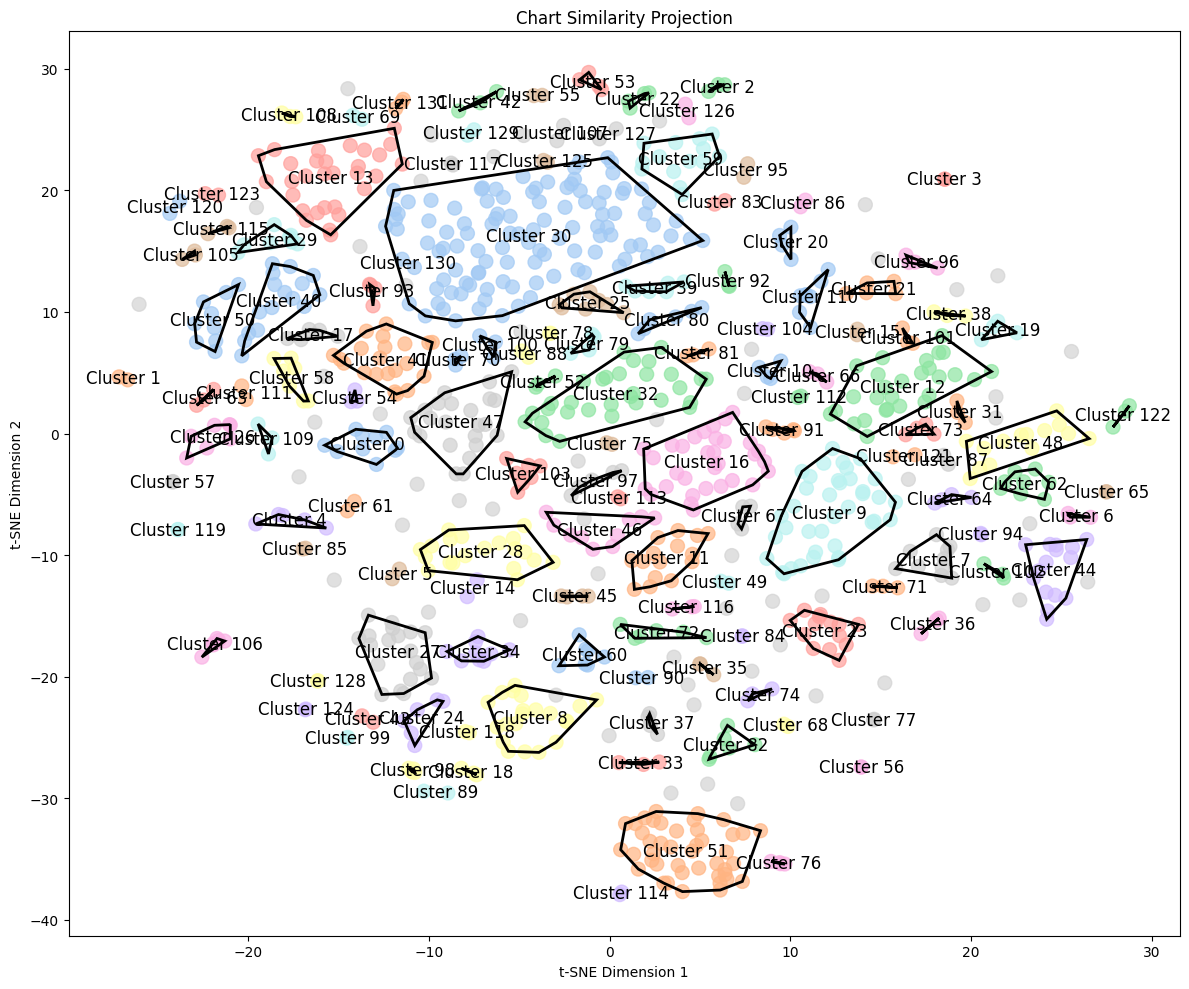

Cluster 119 (Quality Rank: 1):
  - 1650.png (avg. similarity: 0.99)
  - 1960.png (avg. similarity: 0.99)
Cluster 56 (Quality Rank: 2):
  - 392.png (avg. similarity: 0.99)
  - 573.png (avg. similarity: 0.99)
Cluster 3 (Quality Rank: 3):
  - 13.png (avg. similarity: 0.98)
  - 140.png (avg. similarity: 0.98)
Cluster 57 (Quality Rank: 4):
  - 403.png (avg. similarity: 0.99)
  - 1509.png (avg. similarity: 0.99)
Cluster 65 (Quality Rank: 5):
  - 465.png (avg. similarity: 0.97)
  - 1980.png (avg. similarity: 0.97)
Cluster 84 (Quality Rank: 6):
  - 654.png (avg. similarity: 0.98)
  - 872.png (avg. similarity: 0.98)
Cluster 77 (Quality Rank: 7):
  - 541.png (avg. similarity: 0.98)
  - 698.png (avg. similarity: 0.98)
Cluster 128 (Quality Rank: 8):
  - 2076.png (avg. similarity: 0.99)
  - 2082.png (avg. similarity: 0.99)
Cluster 78 (Quality Rank: 9):
  - 547.png (avg. similarity: 0.99)
  - 2366.png (avg. similarity: 0.99)
Cluster 124 (Quality Rank: 10):
  - 1799.png (avg. similarity: 0.99)
  - 18

In [36]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.spatial import ConvexHull, QhullError

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    projection_df['x'], 
    projection_df['y'],
    c=projection_df['color'],
    s=100,
    alpha=0.7
)

unique_clusters = projection_df['cluster'].unique()
patches = []
for cluster_id in sorted(unique_clusters):
    if cluster_id >= 0:
        color = projection_df[projection_df['cluster'] == cluster_id]['color'].iloc[0]
        patches.append(mpatches.Patch(color=color, label=f'Cluster {cluster_id}'))

        # Add cluster name at the centroid
        cluster_points = projection_df[projection_df['cluster'] == cluster_id]
        x_mean = cluster_points['x'].mean()
        y_mean = cluster_points['y'].mean()
        plt.text(x_mean, y_mean,
                 f'Cluster {cluster_id}',
                 fontsize=12,
                 ha='center',
                 va='center')
        

for cluster_id in sorted(unique_clusters):
    if cluster_id >= 0:
        cluster_points = projection_df[projection_df['cluster'] == cluster_id][['x','y']].values
        if len(cluster_points) >= 3: 
            try:
                hull = ConvexHull(cluster_points)
                hull_vertices = hull.vertices
                polygon = plt.Polygon(cluster_points[hull_vertices], fill=False, 
                                      edgecolor='black', linewidth=2)
                plt.gca().add_patch(polygon)
            except QhullError:
                pass
# for i, row in projection_df.iterrows():
#     plt.annotate(
#         row['chart_name'],
#         (row['x'], row['y']),
#         fontsize=8,
#         alpha=0.7
#     )
# plt.legend(handles=patches, title='Clusters')
plt.title('Chart Similarity Projection')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

for i, cluster_id in enumerate(sorted_clusters):
    cluster_charts = projection_df[projection_df['cluster'] == cluster_id]['chart_name'].tolist()
    print(f"Cluster {cluster_id} (Quality Rank: {i+1}):")
    
    chart_indices = [chart_names.index(chart) for chart in cluster_charts]

    for chart_idx, chart in zip(chart_indices, cluster_charts):
        similarities = [similarity_matrix[chart_idx][other_idx] for other_idx in chart_indices if other_idx != chart_idx]
        avg_similarity = sum(similarities) / len(similarities) if similarities else 0.0
        print(f"  - {chart} (avg. similarity: {avg_similarity:.2f})")


## HDBSCAN version

In [24]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn import metrics
import seaborn as sns
from tqdm import tqdm
import hdbscan

def chart_similarity_projection(structured_data, attributes_of_interest=None, method='combined'):
    
    chart_names = list(structured_data.keys())
    n_charts = len(chart_names)
    
    if n_charts <= 1:
        return pd.DataFrame(), []
    
    print(f"Vectorizing charts using {method} text...")
    chart_docs = {}
    for name, data in tqdm(structured_data.items(), desc="Processing Charts"):
        if method == 'attributes':
            text = data.get('attributes_text', '')
        elif method == 'keywords':
            text = data.get('keywords_text', '')
        else:
            text = data.get('combined_text', '')
            
        if text and isinstance(text, str) and text.strip():
            max_len = 100000
            chart_docs[name] = nlp(text[:max_len])
        else:
            chart_docs[name] = nlp("")
    
    similarity_matrix = np.zeros((n_charts, n_charts))
    for i, name1 in enumerate(tqdm(chart_names, desc="Calculating Similarities")):
        for j, name2 in enumerate(chart_names):
            if i == j:
                similarity_matrix[i, j] = 1.0
            elif i < j:
                doc1 = chart_docs.get(name1)
                doc2 = chart_docs.get(name2)
                
                if doc1 and doc2 and doc1.has_vector and doc2.has_vector and doc1.vector_norm and doc2.vector_norm:
                    similarity = doc1.similarity(doc2)
                    similarity_matrix[i, j] = max(0.0, min(1.0, similarity))
                    similarity_matrix[j, i] = similarity_matrix[i, j]
                else:
                    similarity_matrix[i, j] = 0.0
                    similarity_matrix[j, i] = 0.0
    
    feature_matrix = np.array([doc.vector for doc in chart_docs.values()])
    model = TSNE(n_components=2, random_state=0, perplexity=min(30, n_charts-1), metric="cosine")
    tsne_result = model.fit_transform(feature_matrix)

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=3,         
        min_samples=2,              
        cluster_selection_method='eom',  
        
    )
    # distance_matrix = 1 - similarity_matrix
    labels = clusterer.fit_predict(tsne_result)
    number_of_labels = np.unique(labels[labels >= 0]).shape[0]
    palette = sns.color_palette('pastel', number_of_labels)
    palette = palette.as_hex()
    
    colors = [palette[x % len(palette)] if x >= 0 else "#d3d3d3" for x in labels]
    
    result_df = pd.DataFrame({
        'chart_name': chart_names,
        'x': tsne_result[:, 0],
        'y': tsne_result[:, 1],
        'cluster': labels,
        'color': colors,
        'probability': clusterer.probabilities_ 
    })
    
    sorted_clusters = []
    try:
        if np.unique(labels).shape[0] > 1: 
            silhouette_scores = metrics.silhouette_samples(tsne_result, labels)
            mean_silhouette = {}
            
            for i in np.unique(labels):
                if i >= 0: 
                    cluster_scores = silhouette_scores[labels == i]
                    mean_silhouette[i] = np.mean(cluster_scores)
            
            sorted_clusters = [k for k, v in sorted(mean_silhouette.items(), 
                                                    key=lambda item: item[1], 
                                                    reverse=True)]
    except Exception as e:
        print(f"Warning: Could not calculate silhouette scores: {e}")
    
    return result_df, sorted_clusters


In [ ]:
projection_df, sorted_clusters = chart_similarity_projection(
    structured_data,
    method='combined'
)

In [ ]:


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    projection_df['x'], 
    projection_df['y'],
    c=projection_df['color'],
    s=100,
    alpha=0.7
)

# for i, row in projection_df.iterrows():
#     plt.annotate(
#         row['chart_name'],
#         (row['x'], row['y']),
#         fontsize=8,
#         alpha=0.7
#     )

plt.title('Chart Similarity Projection')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.tight_layout()
plt.show()

for i, cluster_id in enumerate(sorted_clusters):
    cluster_charts = projection_df[projection_df['cluster'] == cluster_id]['chart_name'].tolist()
    print(f"Cluster {cluster_id} (Quality Rank: {i+1}):")
    for chart in cluster_charts:
        print(f"  - {chart}")


NameError: name 'chart_similarity_projection' is not defined